# Keypoints mapping aproach B

## Install pre-training model for human posture detection from Paddlehub

In [60]:
#! hub install human_pose_estimation_resnet50_mpii==1.1.1

In [2]:
import os
import cv2
import paddlehub as hub
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
%matplotlib inline

/opt/anaconda3/envs/paddle_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/paddle_env/lib/python3.8/site-packages/_distutils_hack/__init__.py:36: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Display images

In [4]:
# Display the specified path image
def show_img(img_path, size=8):
    im = imread(img_path)
    plt.figure(figsize=(size,size))
    plt.axis("off")
    plt.imshow(im)

# Display the image read by Opencv and convert the image channel to RGB format
def img_show_bgr(image,size=8):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(size,size))
    plt.imshow(image)
    plt.axis("off")
    plt.show() 

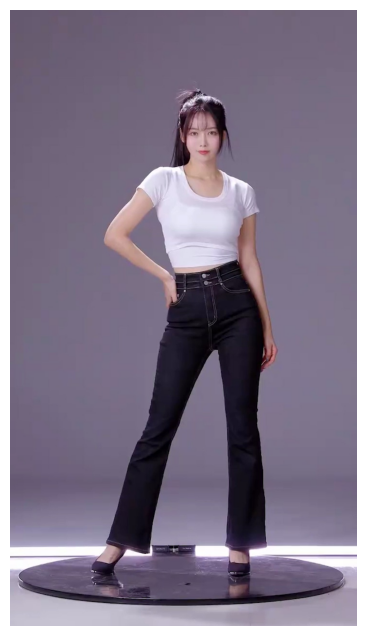

In [77]:
show_img('test/test.jpg')

In [6]:
pose_estimation = hub.Module(name="human_pose_estimation_resnet50_mpii")
result = pose_estimation.keypoint_detection(paths=['test/test.jpg'], visualization=True, output_dir="test/test_output")

image saved in test/test_output/testtime=1727011695.jpg


In [7]:
result

[{'path': 'test/test.jpg',
  'data': OrderedDict([('left_ankle', [127, 1040]),
               ('left_knee', [240, 893]),
               ('left_hip', [315, 653]),
               ('right_hip', [405, 666]),
               ('right_knee', [487, 906]),
               ('right_ankle', [615, 1040]),
               ('pelvis', [360, 653]),
               ('thorax', [352, 440]),
               ('upper_neck', [352, 400]),
               ('head_top', [360, 266]),
               ('right_wrist', [105, 640]),
               ('right_elbow', [217, 560]),
               ('right_shoulder', [285, 453]),
               ('left_shoulder', [420, 426]),
               ('left_elbow', [517, 506]),
               ('left_wrist', [630, 573])])}]

## Adjust Keypoints (no need to adjust distance)

In [8]:
def adjust_keypoints_function(result):
    keypoints = result[0]['data']
    
    new_left_hip = keypoints ['right_hip']
    new_right_hip = keypoints['left_hip']
    new_left_knee = keypoints['right_knee']
    new_right_knee = keypoints['left_knee']
    new_left_ankle = keypoints['right_ankle']
    new_right_ankle = keypoints['left_ankle']

    keypoints['left_hip'] = new_left_hip
    keypoints['right_hip'] = new_right_hip
    
    keypoints['left_knee'] = new_left_knee
    keypoints['right_knee'] = new_right_knee

    keypoints['left_ankle'] = new_left_ankle
    keypoints['right_ankle'] = new_right_ankle

    return keypoints

In [9]:
adjust_keypoints_test = adjust_keypoints_function(result)

In [10]:
adjust_keypoints_test

OrderedDict([('left_ankle', [615, 1040]),
             ('left_knee', [487, 906]),
             ('left_hip', [405, 666]),
             ('right_hip', [315, 653]),
             ('right_knee', [240, 893]),
             ('right_ankle', [127, 1040]),
             ('pelvis', [360, 653]),
             ('thorax', [352, 440]),
             ('upper_neck', [352, 400]),
             ('head_top', [360, 266]),
             ('right_wrist', [105, 640]),
             ('right_elbow', [217, 560]),
             ('right_shoulder', [285, 453]),
             ('left_shoulder', [420, 426]),
             ('left_elbow', [517, 506]),
             ('left_wrist', [630, 573])])

## Keypoint mapping

In [11]:
body_img_path_map = {
    "head" : "puppets_parts_B/head.png",
    "right_arm" : "puppets_parts_B/rightarm.png",
    "right_hand" : "puppets_parts_B/righthand.png",
    "hip": "puppets_parts_B/hips.png",
    "right_leg" : "puppets_parts_B/rightleg.png",
    "left_leg" : "puppets_parts_B/leftleg.png",
    "body" : "puppets_parts_B/body.png",
    "left_arm" : "puppets_parts_B/leftarm.png",
    "left_hand" : "puppets_parts_B/lefthand.png",
}

In [49]:
def get_true_angel(value):
    return value/np.pi*180

def get_angle(x1, y1, x2, y2):
    dx = abs(x1- x2)
    dy = abs(y1- y2)
    result_angele = 0
    if x1 == x2:
        if y1 > y2:
            result_angele = 180
    else:
        if y1!=y2:
            the_angle = int(get_true_angel(np.arctan(dx/dy)))
        if x1 < x2:
            if y1>y2:
                result_angele = 180 - the_angle
            elif y1<y2:
                result_angele = the_angle
            elif y1==y2:
                result_angele = 90
        elif x1 > x2:
            if y1>y2:
                result_angele = -(180 - the_angle)
            elif y1<y2:
                result_angele = -the_angle
            elif y1==y2:
                result_angele = -90
    
    return result_angele

def rotate_bound(image, angle, center):
    """
    Rotate the image according to the given centre point and angle.

    """
    h, w = image.shape[:2]

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int(h * sin + w * cos)
    nH = int(h * cos + w * sin)

    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]
    

    # Fill image with transparent parameters
    rotated_image = cv2.warpAffine(image, M, (nW, nH),  borderValue=(0, 0, 0, 0))
    
    return rotated_image


def get_distences(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

### Left legs, right legs, left hands, right hands

In [50]:
def append_img_by_sk_points(img, append_img_path, first_point, second_point,x0,y0):

    append_image = cv2.imdecode(np.fromfile(append_img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

    img_height, img_width, img_channels = img.shape

    if append_image.shape[2] == 3:
      
        alpha_channel = np.ones((append_image.shape[0], append_image.shape[1]), dtype=np.uint8) * 255
        append_image = cv2.merge([append_image, alpha_channel])

    angle = get_angle(first_point[0], first_point[1], second_point[0], second_point[1])
   
    center = (append_image.shape[1] // 2, append_image.shape[0] // 2) 

    append_image = rotate_bound(append_image, angle=angle, center=center)
   
    if 90 >angle >=0:
        zero_x = int(x0)
        zero_y = int(y0)
    elif -90 <= angle <0:
        zero_x = int(x0)-int(append_image.shape[1]*0.6)
        zero_y = int(y0)
    elif 180>=angle>=90:
        zero_x = int(x0)
        zero_y = int(y0)-int(append_image.shape[0]*0.6)
    elif -180<=angle<-90:
        zero_x = int(x0)-int(append_image.shape[1]*0.6)
        zero_y = int(y0)-int(append_image.shape[0]*0.6)
   
    (b, g, r, a) = cv2.split(append_image)
    for i in range(0, r.shape[0]):
        for j in range(0, r.shape[1]):
            if a[i][j] > 0 and 0 <= zero_y + i < img_height and 0 <= zero_x + j < img_width:
                img[zero_y + i][zero_x + j] = [b[i][j], g[i][j], r[i][j], a[i][j]]

    return img


### Left arm

Need to return coordinates for left-handed rotation of the centre of the circle

In [51]:
def append_img_by_sk_points_left_arm(img, append_img_path, first_point, second_point,x0,y0):

    append_image = cv2.imdecode(np.fromfile(append_img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    img_height, img_width, img_channels = img.shape
    if append_image.shape[2] == 3:
        alpha_channel = np.ones((append_image.shape[0], append_image.shape[1]), dtype=np.uint8) * 255
        append_image = cv2.merge([append_image, alpha_channel])

    angle = get_angle(first_point[0], first_point[1], second_point[0], second_point[1])
    center = (append_image.shape[1] // 2, append_image.shape[0] // 2) 
    append_image = rotate_bound(append_image, angle=angle, center=center)
   
    if 90 >angle >=0:
        zero_x = int(x0)
        zero_y = int(y0)
    elif -90 <= angle <0:
        zero_x = int(x0)-int(append_image.shape[1]*0.6)
        zero_y = int(y0)
    elif 180>=angle>=90:
        zero_x = int(x0)
        zero_y = int(y0)-int(append_image.shape[0]*0.6)
    elif -180<=angle<-90:
        zero_x = int(x0)-int(append_image.shape[1]*0.6)
        zero_y = int(y0)-int(append_image.shape[0]*0.6)

    x1 = zero_x + int(append_image.shape[1]*0.5)
    y1 = zero_y + int(append_image.shape[0]*0.5) 

    (b, g, r, a) = cv2.split(append_image)
    for i in range(0, r.shape[0]):
        for j in range(0, r.shape[1]):
            if a[i][j] > 0 and 0 <= zero_y + i < img_height and 0 <= zero_x + j < img_width:
                img[zero_y + i][zero_x + j] = [b[i][j], g[i][j], r[i][j], a[i][j]]

    return img , x1, y1


### Right arm

Need to return coordinates for right-handed rotation of the centre of the circle

In [52]:
def append_img_by_sk_points_right_arm(img, append_img_path, first_point, second_point,x0,y0):

    append_image = cv2.imdecode(np.fromfile(append_img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

    img_height, img_width, img_channels = img.shape
    if append_image.shape[2] == 3:
        alpha_channel = np.ones((append_image.shape[0], append_image.shape[1]), dtype=np.uint8) * 255
        append_image = cv2.merge([append_image, alpha_channel])

    angle = get_angle(first_point[0], first_point[1], second_point[0], second_point[1])
    center = (append_image.shape[1] // 2, append_image.shape[0] // 2) 
    append_image = rotate_bound(append_image, angle=angle, center=center)
   
    if 90 >angle >=0:
        zero_x = int(x0)
        zero_y = int(y0)
    elif -90 <= angle <0:
        zero_x = int(x0)-int(append_image.shape[1]*0.6)
        zero_y = int(y0)
    elif 180>=angle>=90:
        zero_x = int(x0)
        zero_y = int(y0)-int(append_image.shape[0]*0.6)
    elif -180<=angle<-90:
        zero_x = int(x0)-int(append_image.shape[1]*0.6)
        zero_y = int(y0)-int(append_image.shape[0]*0.6)

    x1 = zero_x - int(append_image.shape[1]*0.5)
    y1 = zero_y + int(append_image.shape[0]*0.5) 

    (b, g, r, a) = cv2.split(append_image)
    for i in range(0, r.shape[0]):
        for j in range(0, r.shape[1]):
            if a[i][j] > 0 and 0 <= zero_y + i < img_height and 0 <= zero_x + j < img_width:
                img[zero_y + i][zero_x + j] = [b[i][j], g[i][j], r[i][j], a[i][j]]

    return img , x1, y1


### Hips, head, body

Disregarding the original coordinate changes of the rotation matrix

In [53]:
def append_img_by_sk_points_other(img, append_img_path, first_point, second_point,x0,y0):

    append_image = cv2.imdecode(np.fromfile(append_img_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

    img_height, img_width, img_channels = img.shape
    if append_image.shape[2] == 3:
        alpha_channel = np.ones((append_image.shape[0], append_image.shape[1]), dtype=np.uint8) * 255
        append_image = cv2.merge([append_image, alpha_channel])

    angle = get_angle(first_point[0], first_point[1], second_point[0], second_point[1])
    center = (append_image.shape[1] // 2, append_image.shape[0] // 2) 
    append_image = rotate_bound(append_image, angle=angle, center=center)
 
    zero_x = int(x0)
    zero_y = int(y0)
 
    (b, g, r, a) = cv2.split(append_image)
    for i in range(0, r.shape[0]):
        for j in range(0, r.shape[1]):
            if a[i][j] > 0 and 0 <= zero_y + i < img_height and 0 <= zero_x + j < img_width:
                img[zero_y + i][zero_x + j] = [b[i][j], g[i][j], r[i][j], a[i][j]]
    

    return img

### Combination

In [73]:
def get_combine_img(img_path, pose_estimation=pose_estimation, body_img_path_map=body_img_path_map):
    
    result = pose_estimation.keypoint_detection(paths=[img_path])
    adjust_keypoints = adjust_keypoints_function(result)
    # background
    canvas_height = 1640 
    canvas_width = 1640  
    backgroup_image = np.ones((canvas_height, canvas_width, 4), dtype=np.uint8) * 255 
    backgroup_image[:,:, 3] = 255 
    
    image_flag = backgroup_image
    
    # right arm
    image_flag, right_hand_x, right_hand_y = append_img_by_sk_points_right_arm(image_flag, body_img_path_map['right_arm'],first_point=adjust_keypoints['right_shoulder'],
                    second_point=adjust_keypoints['right_elbow'],x0=710,y0=520)
    # right hand
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['right_hand'],first_point=adjust_keypoints['right_elbow'],
                    second_point=adjust_keypoints['right_wrist'],x0=right_hand_x,y0=right_hand_y)
    

    # hip, need the centre of two knees keypoints
    second_point_hip = (int((adjust_keypoints['right_knee'][0]+ adjust_keypoints['left_knee'][0])/2),int((adjust_keypoints['right_knee'][1]+ adjust_keypoints['left_knee'][1])/2))
    image_flag = append_img_by_sk_points_other(image_flag, body_img_path_map['hip'],first_point=adjust_keypoints['pelvis'],
                    second_point=second_point_hip,x0=730,y0=850)
    
    # head
    image_flag = append_img_by_sk_points_other(image_flag, body_img_path_map['head'],first_point=adjust_keypoints['head_top'],
                    second_point=adjust_keypoints['upper_neck'],x0=700,y0=44)
    
    # body
    image_flag = append_img_by_sk_points_other(image_flag, body_img_path_map['body'],first_point=(0,0),
                    second_point=(0,0),x0=760,y0=425)
    # right leg
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['right_leg'],first_point=adjust_keypoints['right_knee'],
                    second_point=adjust_keypoints['right_ankle'],x0=675,y0=1100)
    
    # left leg
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['left_leg'],first_point=adjust_keypoints['left_knee'],
                    second_point=adjust_keypoints['left_ankle'],x0=860,y0=1100)
    
    # left arm
    image_flag, left_hand_x, left_hand_y = append_img_by_sk_points_left_arm(image_flag, body_img_path_map['left_arm'],first_point=adjust_keypoints['left_shoulder'],
                    second_point=adjust_keypoints['left_elbow'],x0=880,y0=520)
    # left hand
    image_flag = append_img_by_sk_points(image_flag, body_img_path_map['left_hand'],first_point=adjust_keypoints['left_elbow'],
                    second_point=adjust_keypoints['left_wrist'],x0=left_hand_x,y0=left_hand_y)
    

    original_image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    original_height, original_width = original_image.shape[:2]
    scale_factor = canvas_height / original_height
    new_width = int(original_width * scale_factor)
    original_image_resized = cv2.resize(original_image, (new_width, canvas_height))
    image_flag_rgb = image_flag[:, :, :3]  

    final_image = np.hstack((original_image_resized, image_flag_rgb))
    return final_image

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


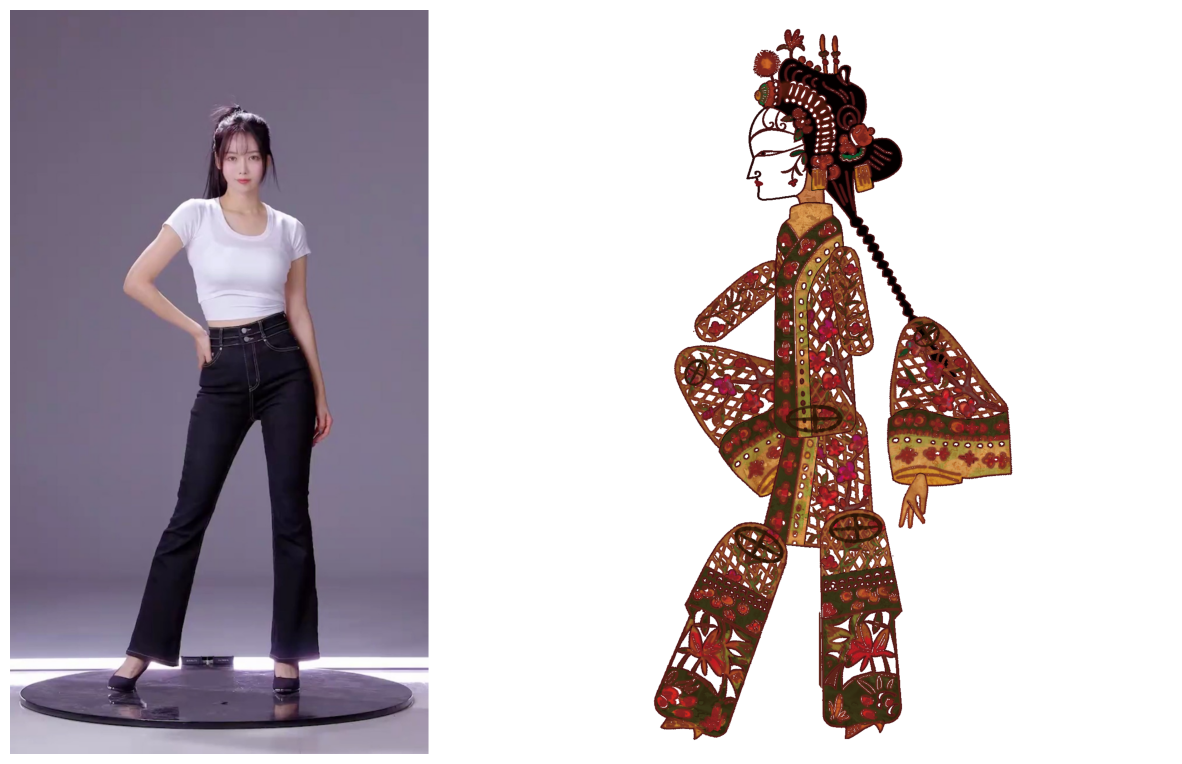

In [74]:
image_flag = get_combine_img(img_path='test/test.jpg', pose_estimation=pose_estimation, body_img_path_map=body_img_path_map)
img_show_bgr(image_flag, size=15)

## Compositing Generated Video and Audio

In [62]:
input_video = 'test.mp4'

In [63]:
def transform_video_to_image(video_file_path, img_path):

    video_capture = cv2.VideoCapture(video_file_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    count = 0
    while(True):
        ret, frame = video_capture.read() 
        if ret:
            cv2.imwrite(img_path + '%d.jpg' % count, frame)
            count += 1
        else:
            break
    video_capture.release()
    return fps

In [ ]:
fps = transform_video_to_image(input_video, 'test/test_video/')

In [65]:
def analysis_pose(input_frame_path, output_frame_path, is_print=True):
    file_items = os.listdir(input_frame_path)
    file_len = len(file_items)
    for i, file_item in enumerate(file_items):
        if is_print:
            print(i+1,'/', file_len, ' ', os.path.join(output_frame_path, file_item))
        combine_img = get_combine_img(os.path.join(input_frame_path, file_item))
        cv2.imwrite(os.path.join(output_frame_path, file_item), combine_img)

In [75]:
analysis_pose('test/test_video', 'test/test_video_results_B', is_print=False)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [67]:
def combine_image_to_video(comb_path, output_file_path, fps=30, is_print=False):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')    
    
    file_items = os.listdir(comb_path)
    file_len = len(file_items)
    # print(comb_path, file_items)
    if file_len > 0 :
        temp_img = cv2.imread(os.path.join(comb_path, file_items[0]))
        img_height, img_width = temp_img.shape[0], temp_img.shape[1]
        
        out = cv2.VideoWriter(output_file_path, fourcc, fps, (img_width, img_height))

        for i in range(file_len):
            pic_name = os.path.join(comb_path, str(i)+".jpg")
            if is_print:
                print(i+1,'/', file_len, ' ', pic_name)
            img = cv2.imread(pic_name)
            out.write(img)
        out.release()

In [76]:
combine_image_to_video('test/test_video_results_B', 'test/test_video_results_B.mp4', fps =30)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
[ WARN:0@15277.497] global loadsave.cpp:241 findDecoder imread_('test/test_video_results_B/609.jpg'): can't open/read file: check file path/integrity
